In [1]:
import os
import re
import random
import pickle
import json
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter, defaultdict
from dotenv import load_dotenv
from datasets import load_dataset, Dataset, DatasetDict
from openai import OpenAI
from items import Item
from loaders import ItemLoader
from testing import Tester

In [2]:
load_dotenv("../.env")

True

## Loading the Dataset

In [3]:
dataset = load_dataset("McAuley-Lab/Amazon-Reviews-2023", "raw_meta_Appliances", split="full", trust_remote_code=True)

## Exploring the Dataset

In [4]:
print(f"Number of Appliances: {len(dataset):,}")

Number of Appliances: 94,327


In [5]:
datapoint = dataset[2]

In [6]:
print(datapoint["title"])
print(datapoint["description"])
print(datapoint["features"])
print(datapoint["details"])
print(datapoint["price"])

Clothes Dryer Drum Slide, General Electric, Hotpoint, WE1M333, WE1M504
['Brand new dryer drum slide, replaces General Electric, Hotpoint, RCA, WE1M333, WE1M504.']
[]
{"Manufacturer": "RPI", "Part Number": "WE1M333,", "Item Weight": "0.352 ounces", "Package Dimensions": "5.5 x 4.7 x 0.4 inches", "Item model number": "WE1M333,", "Is Discontinued By Manufacturer": "No", "Item Package Quantity": "1", "Batteries Included?": "No", "Batteries Required?": "No", "Best Sellers Rank": {"Tools & Home Improvement": 1315213, "Parts & Accessories": 181194}, "Date First Available": "February 25, 2014"}
None


In [7]:
# How many prices?

prices = 0
for datapoint in dataset:
    try:
        price = float(datapoint["price"])
        if price > 0:
            prices += 1
    except ValueError as e:
        pass

print(f"There are {prices:,} with prices which is {prices/len(dataset)*100:,.1f}%")

There are 46,726 with prices which is 49.5%


In [8]:
# For those with prices, gather the price and the length

prices = []
lengths = []
for datapoint in dataset:
    try:
        price = float(datapoint["price"])
        if price > 0:
            prices.append(price)
            contents = datapoint["title"] + str(datapoint["description"]) + str(datapoint["features"]) + str(datapoint["details"])
            lengths.append(len(contents))
    except ValueError as e:
        pass

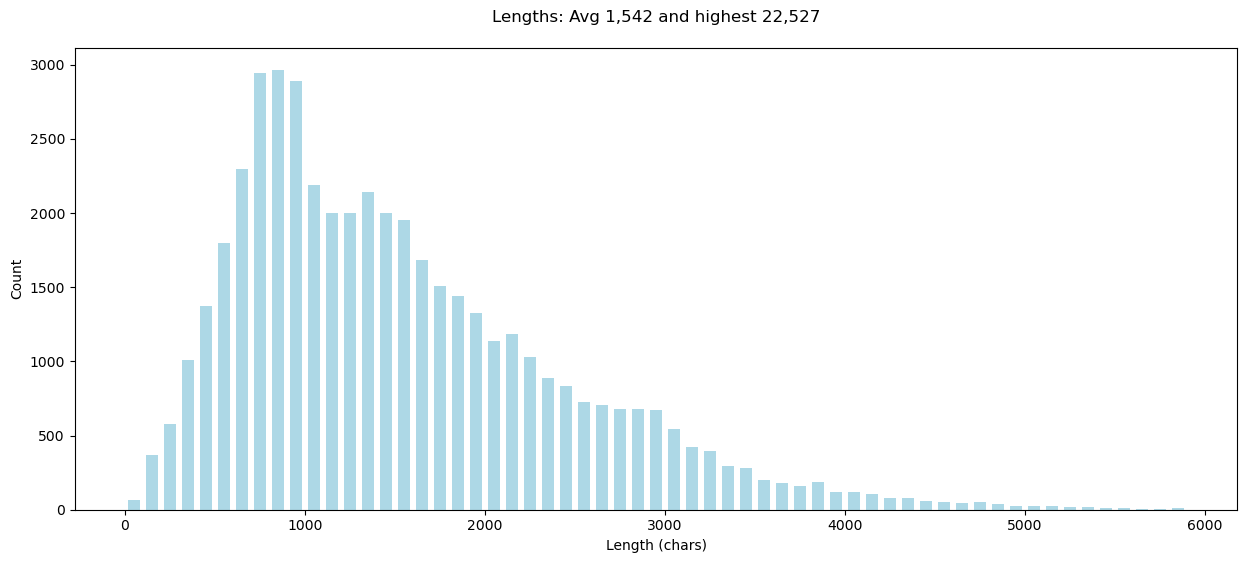

In [9]:
# Plot the distribution of lengths

plt.figure(figsize=(15, 6))
plt.title(f"Lengths: Avg {sum(lengths)/len(lengths):,.0f} and highest {max(lengths):,}\n")
plt.xlabel('Length (chars)')
plt.ylabel('Count')
plt.hist(lengths, rwidth=0.7, color="lightblue", bins=range(0, 6000, 100))
plt.show()

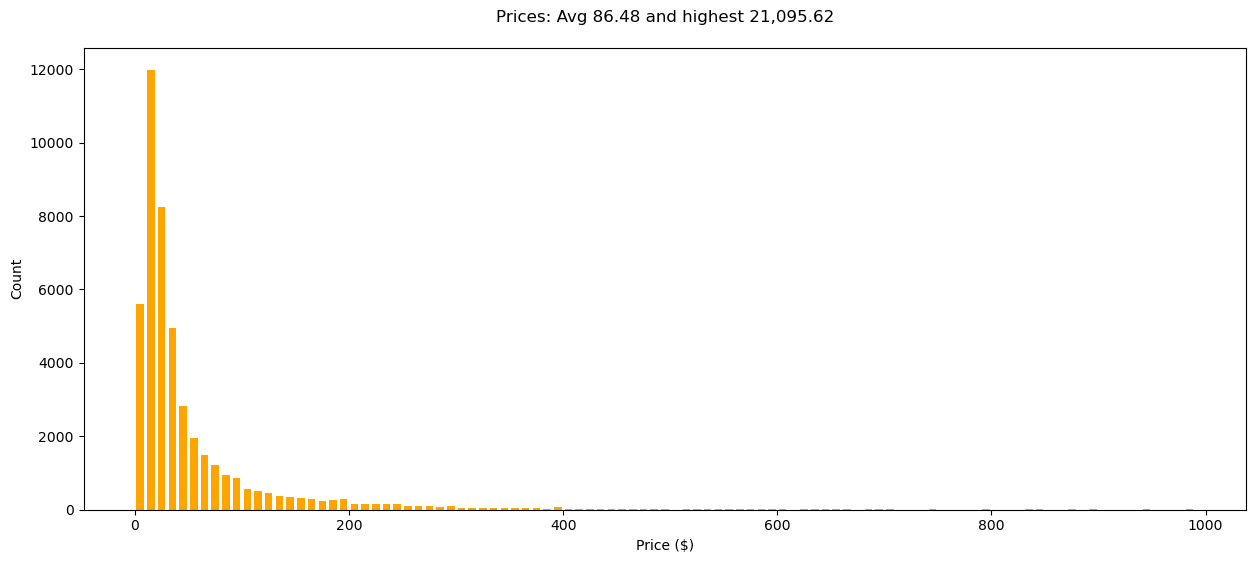

In [10]:
# Plot the distribution of prices

plt.figure(figsize=(15, 6))
plt.title(f"Prices: Avg {sum(prices)/len(prices):,.2f} and highest {max(prices):,}\n")
plt.xlabel('Price ($)')
plt.ylabel('Count')
plt.hist(prices, rwidth=0.7, color="orange", bins=range(0, 1000, 10))
plt.show()

## Data Curation

In [11]:
# Create an Item object for each with a price

items = []
for datapoint in dataset:
    try:
        price = float(datapoint["price"])
        if price > 0:
            item = Item(datapoint, price)
            if item.include:
                items.append(item)
    except ValueError as e:
        pass

print(f"There are {len(items):,} items")

There are 30,041 items


In [12]:
items[1]

<WP67003405 67003405 Door Pivot Block - Compatible Kenmore KitchenAid Maytag Whirlpool Refrigerator - Replaces AP6010352 8208254 PS11743531 - Quick DIY Repair Solution = $16.52>

In [13]:
# Investigate the prompt that will be used during training - the model learns to complete this

print(items[100].prompt)

How much does this cost to the nearest dollar?

2-Pack Replacement for Samsung Refrigerator Water Filter - Compatible with Samsung HAF-CIN Fridge Water Filter Cartridge
This is a Denali Pure Brand replacement part, NOT an OEM product. All mentions of brand names or model descriptions are made strictly to illustrate compatibility. All brand names and logos are registered trademarks of their respective owners. This product is not affiliated with any OEM brands and is not covered under any warranties offered by the original manufacturers. Any warranties for this product are offered solely by Denali Pure. Replacement for Filter Manufacturer Denali Pure, Part model number Is Discontinued No, Rank Tools & Home Improvement In-Refrigerator Water Filters 3632, Available May 27, 2015, Duration 6 \tmonths, External Testing Certification ANSI, NSF

Price is $22.00


In [14]:
# Investigate the prompt that will be used during testing - the model has to complete this

print(items[100].test_prompt())

How much does this cost to the nearest dollar?

2-Pack Replacement for Samsung Refrigerator Water Filter - Compatible with Samsung HAF-CIN Fridge Water Filter Cartridge
This is a Denali Pure Brand replacement part, NOT an OEM product. All mentions of brand names or model descriptions are made strictly to illustrate compatibility. All brand names and logos are registered trademarks of their respective owners. This product is not affiliated with any OEM brands and is not covered under any warranties offered by the original manufacturers. Any warranties for this product are offered solely by Denali Pure. Replacement for Filter Manufacturer Denali Pure, Part model number Is Discontinued No, Rank Tools & Home Improvement In-Refrigerator Water Filters 3632, Available May 27, 2015, Duration 6 \tmonths, External Testing Certification ANSI, NSF

Price is $


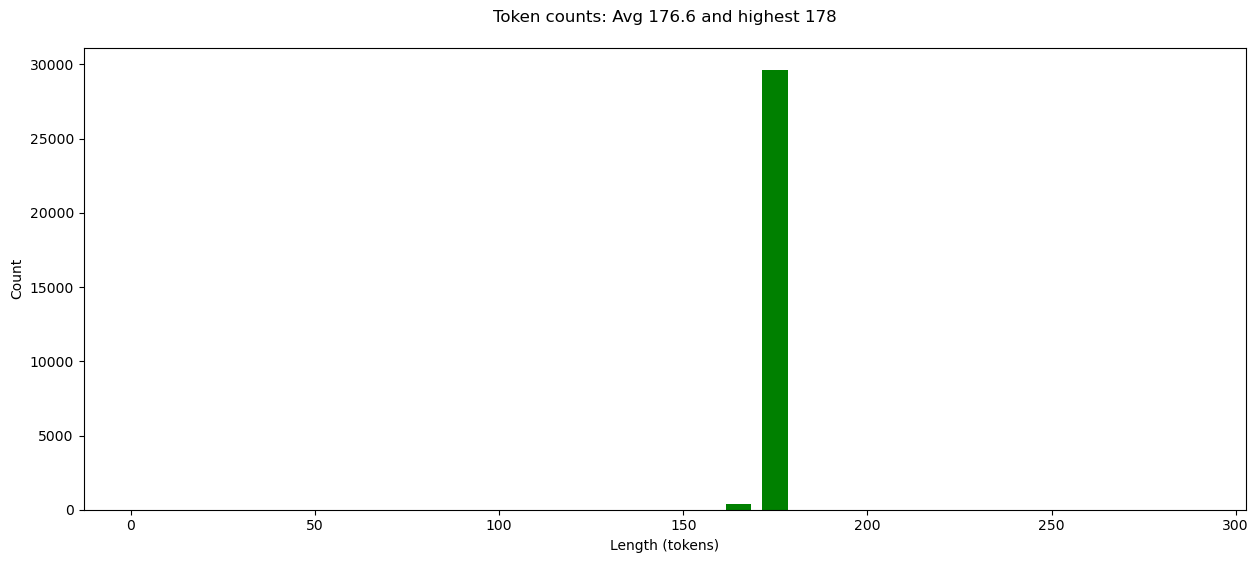

In [15]:
# Plot the distribution of token counts

tokens = [item.token_count for item in items]
plt.figure(figsize=(15, 6))
plt.title(f"Token counts: Avg {sum(tokens)/len(tokens):,.1f} and highest {max(tokens):,}\n")
plt.xlabel('Length (tokens)')
plt.ylabel('Count')
plt.hist(tokens, rwidth=0.7, color="green", bins=range(0, 300, 10))
plt.show()

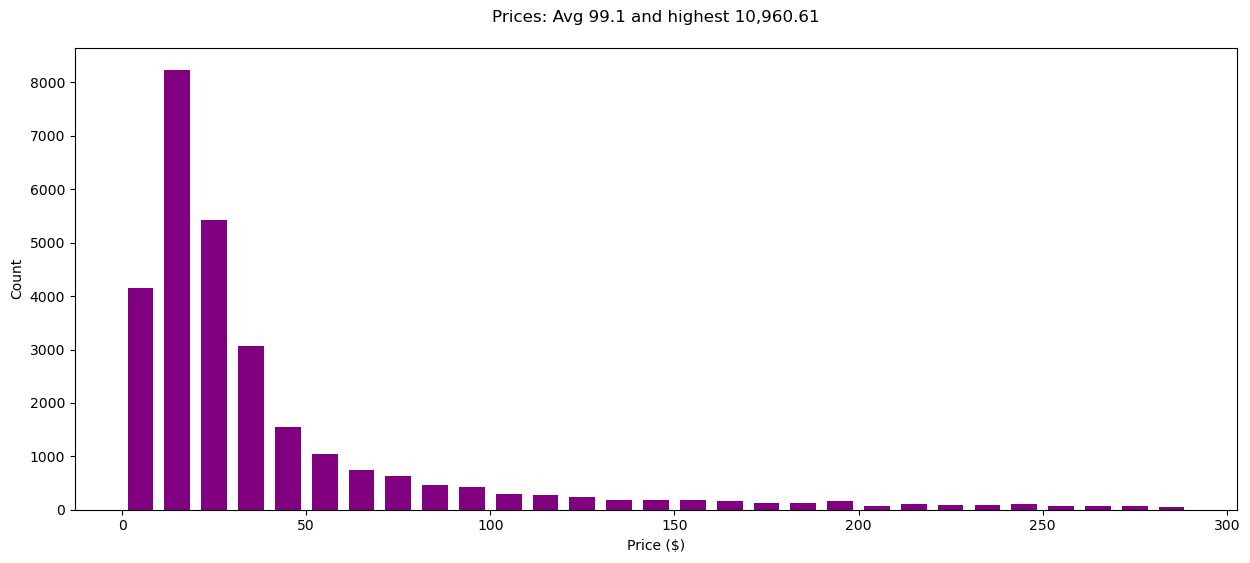

In [16]:
# Plot the distribution of prices

prices = [item.price for item in items]
plt.figure(figsize=(15, 6))
plt.title(f"Prices: Avg {sum(prices)/len(prices):,.1f} and highest {max(prices):,}\n")
plt.xlabel('Price ($)')
plt.ylabel('Count')
plt.hist(prices, rwidth=0.7, color="purple", bins=range(0, 300, 10))
plt.show()

In [17]:
# Load in the same dataset as last time, this time with ItemLoader

os.environ["TOKENIZERS_PARALLELISM"] = "false"
items = ItemLoader("Appliances").load()

Loading dataset Appliances


100%|██████████| 95/95 [00:10<00:00,  8.78it/s]


Completed Appliances with 29,470 datapoints in 0.2 mins


In [18]:
# Look for a familiar item...

print(items[1].prompt)

How much does this cost to the nearest dollar?

Door Pivot Block - Compatible Kenmore KitchenAid Maytag Whirlpool Refrigerator - Replaces - Quick DIY Repair Solution
Pivot Block For Vernicle Mullion Strip On Door - A high-quality exact equivalent for part numbers and Compatibility with major brands - Door Guide is compatible with Whirlpool, Amana, Dacor, Gaggenau, Hardwick, Jenn-Air, Kenmore, KitchenAid, and Maytag. Quick DIY repair - Refrigerator Door Guide Pivot Block Replacement will help if your appliance door doesn't open or close. Wear work gloves to protect your hands during the repair process. Attentive support - If you are uncertain about whether the block fits your refrigerator, we will help. We generally put forth a valiant effort

Price is $17.00


## Now Let's Scale Up

In [19]:
dataset_names = [
    "Automotive",
    "Electronics",
    "Office_Products",
    "Tools_and_Home_Improvement",
    "Cell_Phones_and_Accessories",
    "Toys_and_Games",
    "Appliances",
    "Musical_Instruments",
]

In [20]:
items = []
for dataset_name in dataset_names:
    loader = ItemLoader(dataset_name)
    items.extend(loader.load())

Loading dataset Automotive


100%|██████████| 2004/2004 [04:23<00:00,  7.62it/s]


Completed Automotive with 923,534 datapoints in 4.5 mins
Loading dataset Electronics


100%|██████████| 1611/1611 [02:26<00:00, 10.96it/s]


Completed Electronics with 447,573 datapoints in 2.6 mins
Loading dataset Office_Products


100%|██████████| 711/711 [01:14<00:00,  9.53it/s]


Completed Office_Products with 241,427 datapoints in 1.3 mins
Loading dataset Tools_and_Home_Improvement


100%|██████████| 1474/1474 [02:41<00:00,  9.13it/s]


Completed Tools_and_Home_Improvement with 543,783 datapoints in 2.8 mins
Loading dataset Cell_Phones_and_Accessories


100%|██████████| 1289/1289 [01:31<00:00, 14.08it/s]


Completed Cell_Phones_and_Accessories with 239,806 datapoints in 1.6 mins
Loading dataset Toys_and_Games


100%|██████████| 891/891 [01:39<00:00,  8.96it/s]


Completed Toys_and_Games with 342,591 datapoints in 1.7 mins
Loading dataset Appliances


100%|██████████| 95/95 [00:13<00:00,  6.84it/s]


Completed Appliances with 29,470 datapoints in 0.3 mins
Loading dataset Musical_Instruments


100%|██████████| 214/214 [00:21<00:00,  9.80it/s]


Completed Musical_Instruments with 67,345 datapoints in 0.4 mins


In [21]:
print(f"A grand total of {len(items):,} items")

A grand total of 2,835,529 items


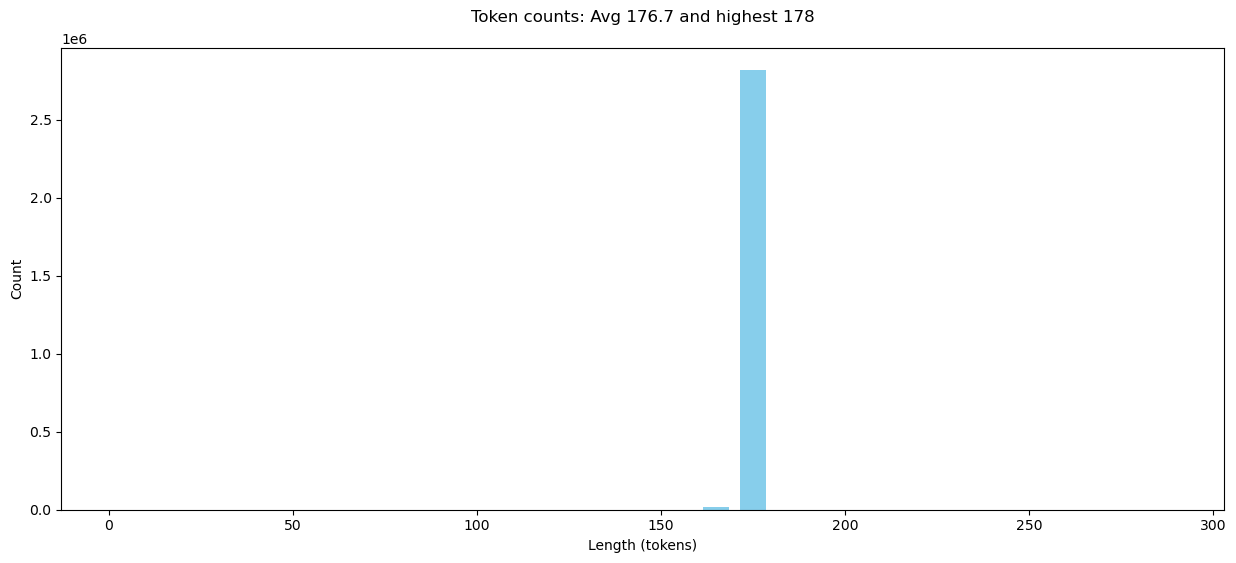

In [22]:
# Plot the distribution of token counts again

tokens = [item.token_count for item in items]
plt.figure(figsize=(15, 6))
plt.title(f"Token counts: Avg {sum(tokens)/len(tokens):,.1f} and highest {max(tokens):,}\n")
plt.xlabel('Length (tokens)')
plt.ylabel('Count')
plt.hist(tokens, rwidth=0.7, color="skyblue", bins=range(0, 300, 10))
plt.show()

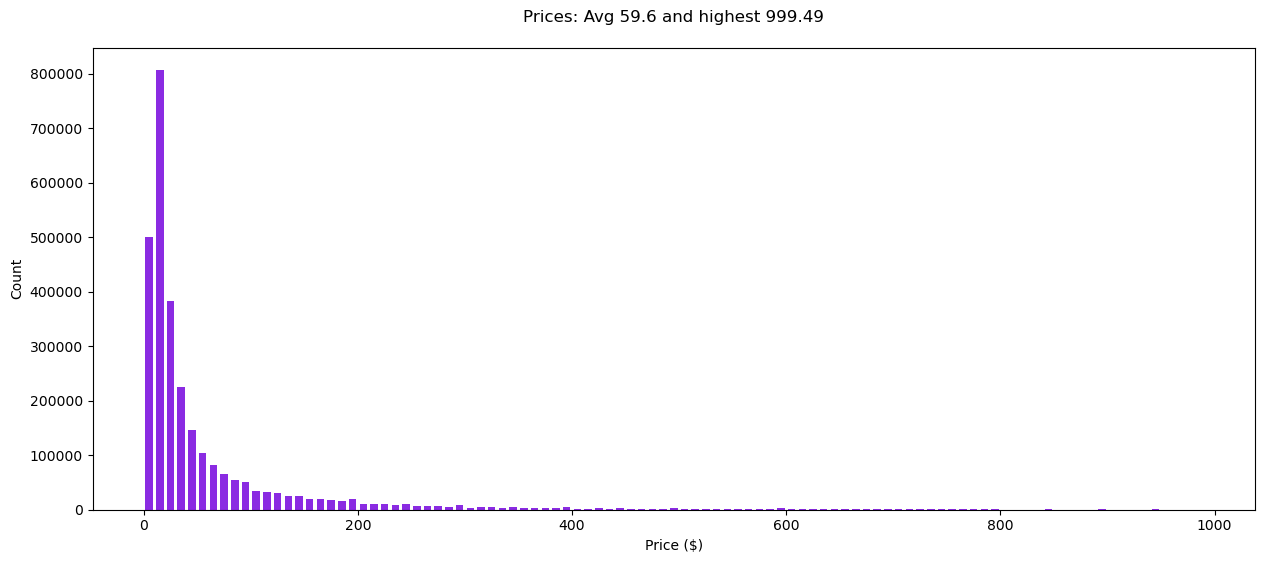

In [23]:
# Plot the distribution of prices

prices = [item.price for item in items]
plt.figure(figsize=(15, 6))
plt.title(f"Prices: Avg {sum(prices)/len(prices):,.1f} and highest {max(prices):,}\n")
plt.xlabel('Price ($)')
plt.ylabel('Count')
plt.hist(prices, rwidth=0.7, color="blueviolet", bins=range(0, 1000, 10))
plt.show()

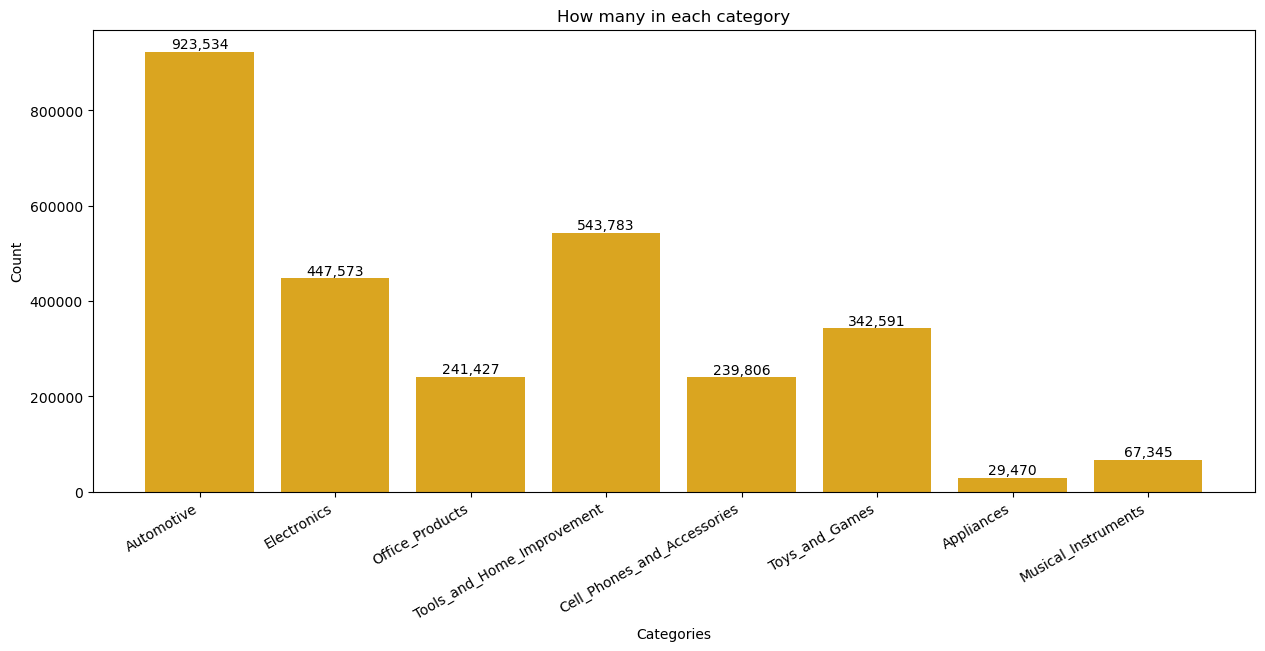

In [24]:
category_counts = Counter()
for item in items:
    category_counts[item.category]+=1

categories = category_counts.keys()
counts = [category_counts[category] for category in categories]

# Bar chart by category
plt.figure(figsize=(15, 6))
plt.bar(categories, counts, color="goldenrod")
plt.title('How many in each category')
plt.xlabel('Categories')
plt.ylabel('Count')

plt.xticks(rotation=30, ha='right')

# Add value labels on top of each bar
for i, v in enumerate(counts):
    plt.text(i, v, f"{v:,}", ha='center', va='bottom')

# Display the chart
plt.show()

### Let's craft a dataset which is more balanced in terms of prices. Less heavily scewed to cheap items, with an average that's higher than $60. Try to balance out the categories - fewer Automotive items.

In [25]:
# Create a dict with a key of each price from $1 to $999
# And in the value, put a list of items with that price (to nearest round number)

slots = defaultdict(list)
for item in items:
    slots[round(item.price)].append(item)

In [26]:
# Create a dataset called "sample" which tries to more evenly take from the range of prices
# and gives more weight to items from categories other than Automotive
# Set random seed for reproducibility

np.random.seed(42)
random.seed(42)
sample = []
for i in range(1, 1000):
    slot = slots[i]
    if i>=240:
        sample.extend(slot)
    elif len(slot) <= 1200:
        sample.extend(slot)
    else:
        weights = np.array([1 if item.category=='Automotive' else 5 for item in slot])
        weights = weights / np.sum(weights)
        selected_indices = np.random.choice(len(slot), size=1200, replace=False, p=weights)
        selected = [slot[i] for i in selected_indices]
        sample.extend(selected)

print(f"There are {len(sample):,} items in the sample")

There are 410,035 items in the sample


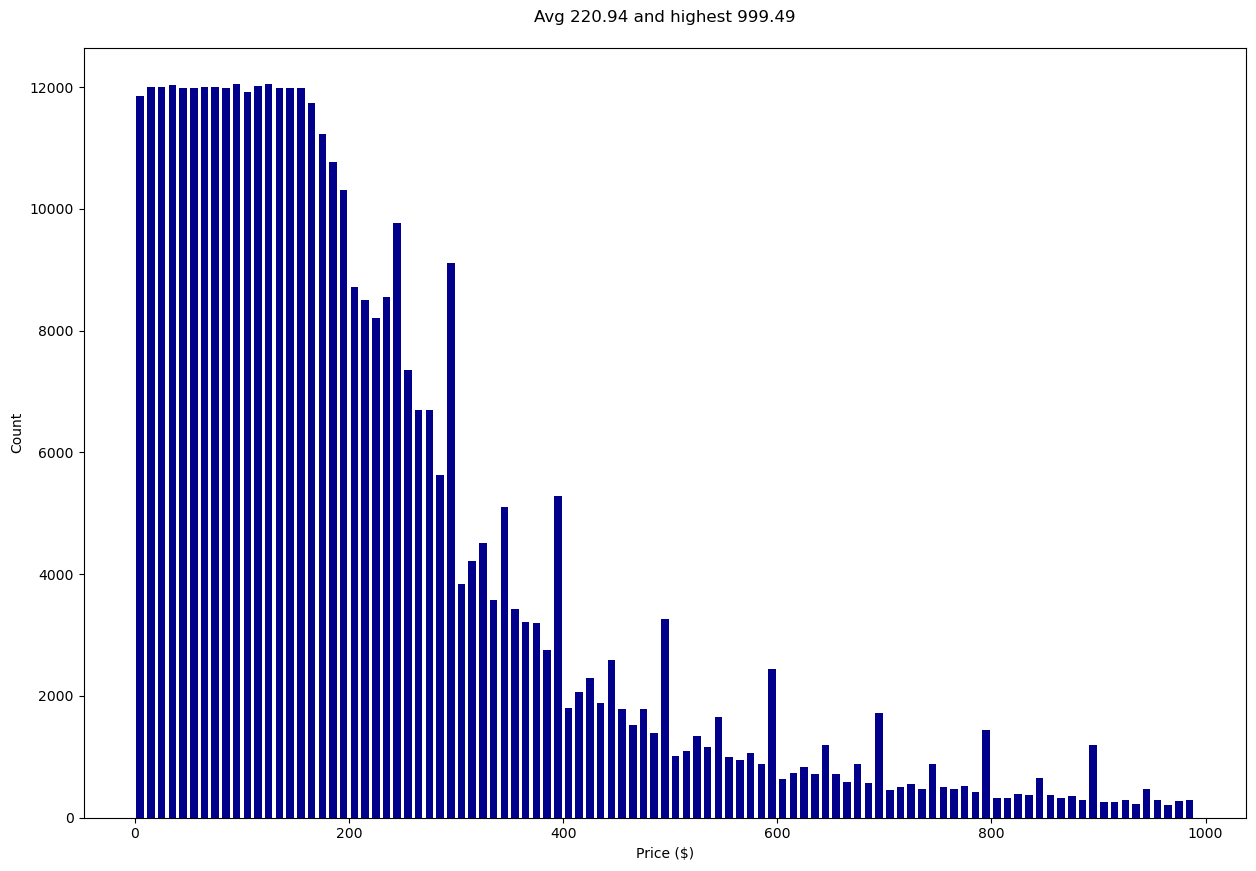

In [27]:
# Plot the distribution of prices in sample

prices = [float(item.price) for item in sample]
plt.figure(figsize=(15, 10))
plt.title(f"Avg {sum(prices)/len(prices):.2f} and highest {max(prices):,.2f}\n")
plt.xlabel('Price ($)')
plt.ylabel('Count')
plt.hist(prices, rwidth=0.7, color="darkblue", bins=range(0, 1000, 10))
plt.show()

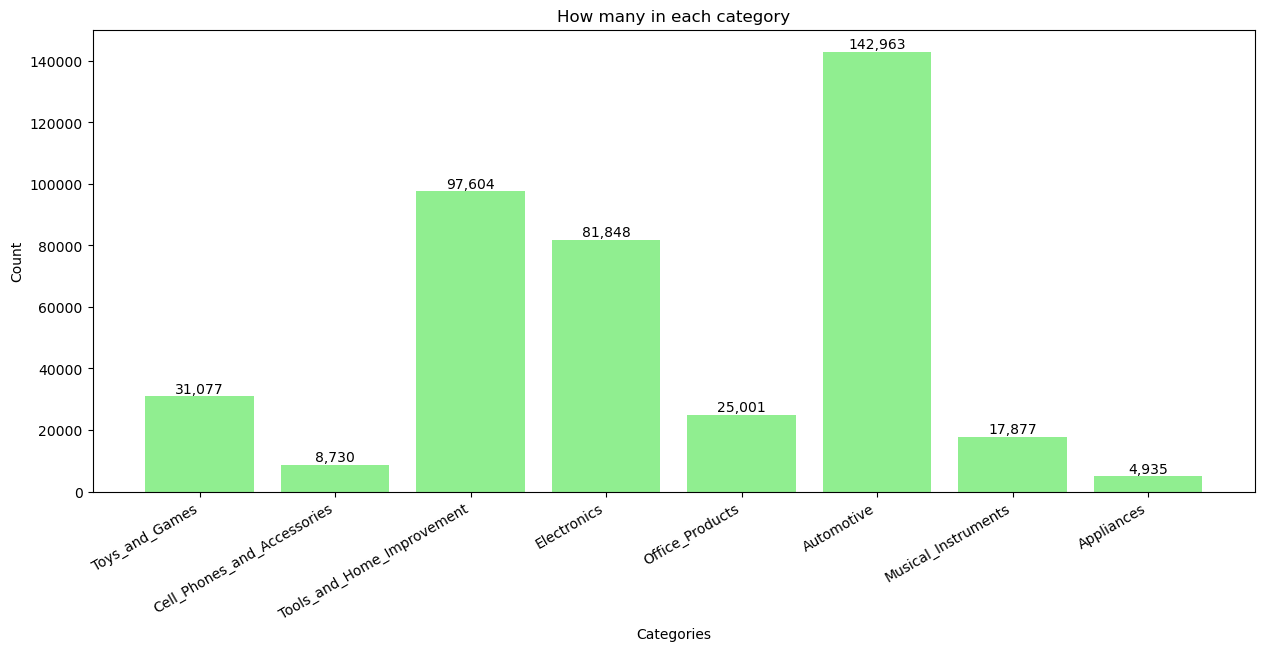

In [28]:
# OK, we did well in terms of raising the average price and having a smooth-ish population of prices
# Let's see the categories

category_counts = Counter()
for item in sample:
    category_counts[item.category]+=1

categories = category_counts.keys()
counts = [category_counts[category] for category in categories]

# Create bar chart
plt.figure(figsize=(15, 6))
plt.bar(categories, counts, color="lightgreen")

# Customize the chart
plt.title('How many in each category')
plt.xlabel('Categories')
plt.ylabel('Count')

plt.xticks(rotation=30, ha='right')

# Add value labels on top of each bar
for i, v in enumerate(counts):
    plt.text(i, v, f"{v:,}", ha='center', va='bottom')

# Display the chart
plt.show()

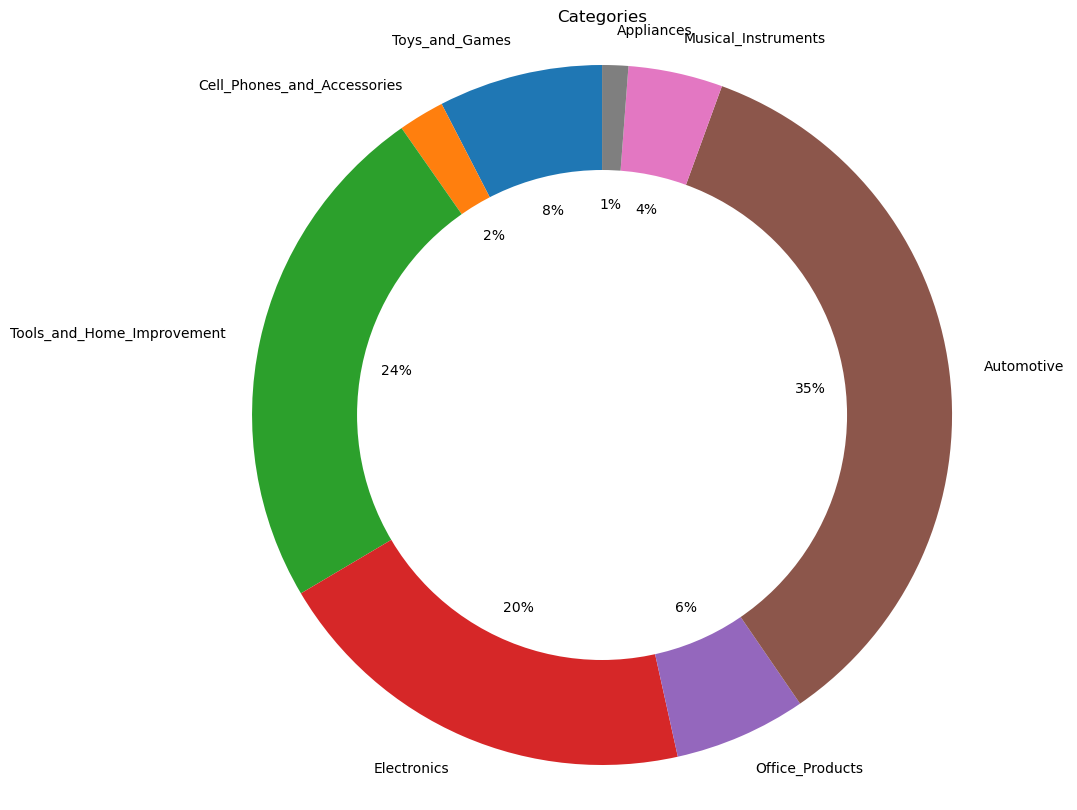

In [29]:
plt.figure(figsize=(12, 10))
plt.pie(counts, labels=categories, autopct='%1.0f%%', startangle=90)

centre_circle = plt.Circle((0,0), 0.70, fc='white')
fig = plt.gcf()
fig.gca().add_artist(centre_circle)
plt.title('Categories')

plt.axis('equal')  

plt.show()

## Dataset Curated!
### Let's do some final checks

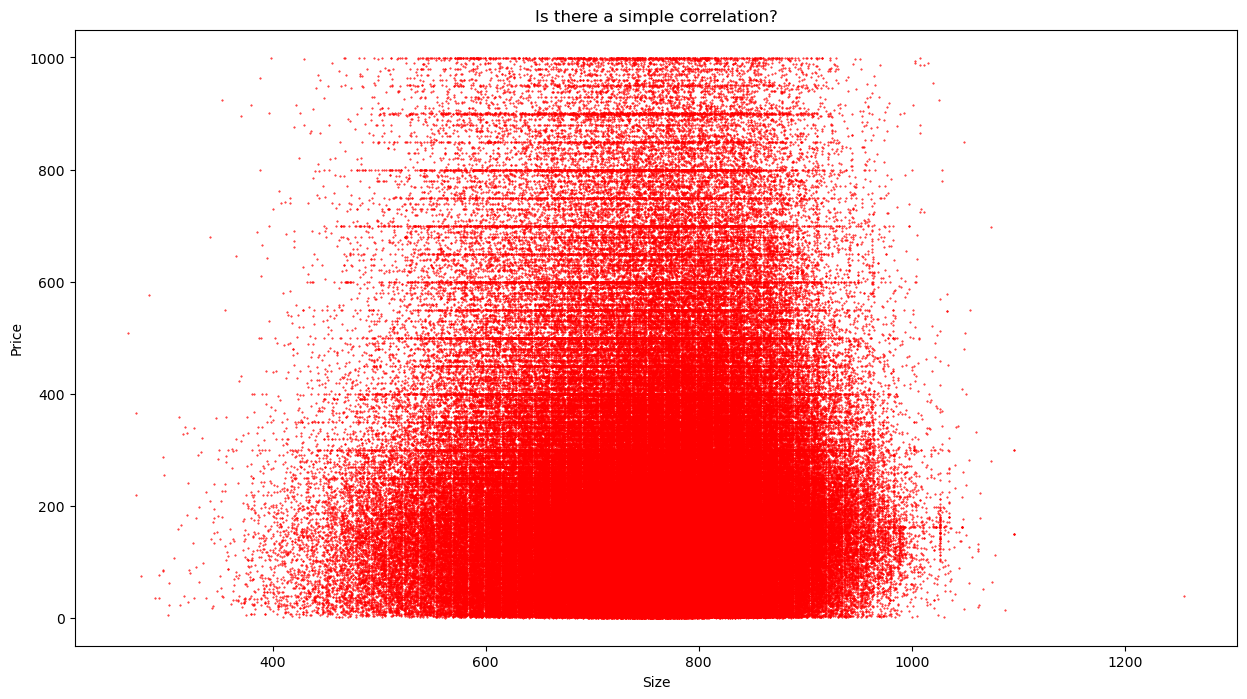

In [30]:
# How does the price vary with the character count of the prompt?

sizes = [len(item.prompt) for item in sample]
prices = [item.price for item in sample]

plt.figure(figsize=(15, 8))
plt.scatter(sizes, prices, s=0.2, color="red")

plt.xlabel('Size')
plt.ylabel('Price')
plt.title('Is there a simple correlation?')

plt.show()

In [31]:
def report(item):
    prompt = item.prompt
    tokens = Item.tokenizer.encode(item.prompt)
    print(prompt)
    print(tokens[-10:])
    print(Item.tokenizer.batch_decode(tokens[-10:]))

In [32]:
report(sample[398000])

How much does this cost to the nearest dollar?

GIGABYTE AORUS GeForce RTX 3070 Master 8G Graphics Card, 3X WINDFORCE Fans, 8GB GDDR6, M-8GD REV2.0 Video Card
NVIDIA Ampere Streaming Multiprocessors 2nd Generation RT Cores 3rd Generation Tensor Cores Powered by GeForce RTX 3070 Integrated with 8GB GDDR6 memory interface MAX-COVERED cooling LCD Edge View RGB Fusion 2.0 3x DisplayPort 1.4a, 2x HDMI 2.1, 1x HDMI 2.0 Protection metal back plate 4 years warranty (Online registration required) LHR (Lite Hash Rate) version Core Clock 184

Price is $745.00
[68890, 223, 7965, 271, 20967, 344, 957, 29444, 16, 504]
[' Clock', ' ', '184', '\n\n', 'Price', ' is', ' $', '745', '.', '00']


### It's time to break down our data into a training, test and validation dataset.

In [33]:
random.seed(42)
random.shuffle(sample)
train = sample[:400_000]
test = sample[400_000:402_000]
print(f"Divided into a training set of {len(train):,} items and test set of {len(test):,} items")

Divided into a training set of 400,000 items and test set of 2,000 items


In [34]:
print(train[0].prompt)

How much does this cost to the nearest dollar?

MGP Caliper Covers Caliper Cover, Set of 4 (Yellow Engraved Front and Rear Powder Coat Finish Black Characters)
MGP Caliper Covers are manufactured in the USA with T-6061 aerospace grade aluminum, TIG welded for strength, powder-coated for durability, and includes a patented stainless steel fastening system. Each set is engineered specifically for the brake caliper to ensure proper fit and finish. No adhesives, tape, or caliper modifications are required. Typical installation time is one hour from start to finish. Enhances wheel appearance and curbside appeal Substantial Brake dust reduction Patented fastening system ensures simple and secure installation No special tools, adhesives or caliper modification required Constructed with aluminum and Stainless Steel materials Manufacturer MGP Caliper

Price is $290.00


In [35]:
print(test[0].test_prompt())

How much does this cost to the nearest dollar?

Pavilion Gift Company 46017 Pedigree Pals Figurine, Himalayan Cat
My Pedigree Pals by Pavilion Gift Company is a fabulous range of finely sculpted dogs and cats creatively designed by British artist Dean Kendric. Beautifully smooth to the touch, this collection has fantastic tactile appeal and captures those adoring expressions and unique personalities of our faithful friends. Made with high quality resin 2012 UK Gift of the year Comes uniquely packaged in a tin which becomes a money box; The back of the tin contains a biography about the unique breed Theme Animal, Brand Pavilion Gift Company, Cartoon Character Cat, Room Type Office, Living Room, Bedroom, Pieces 1, Weight 13.9 ounces, Assembly Required No, s 1, Collection Name Animal,

Price is $


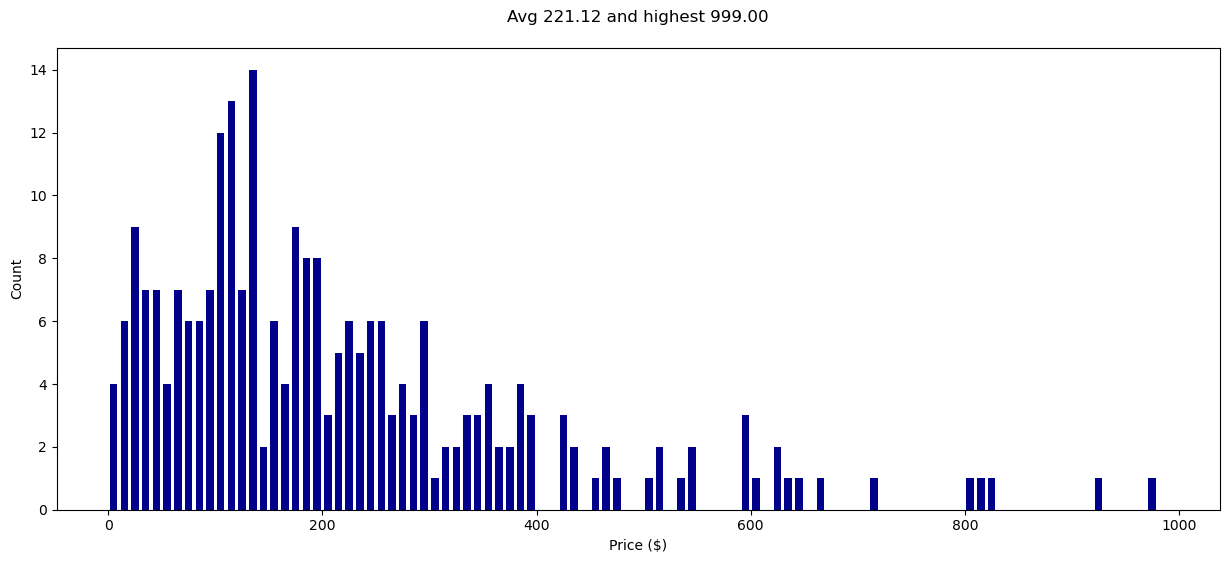

In [36]:
# Plot the distribution of prices in the first 250 test points

prices = [float(item.price) for item in test[:250]]
plt.figure(figsize=(15, 6))
plt.title(f"Avg {sum(prices)/len(prices):.2f} and highest {max(prices):,.2f}\n")
plt.xlabel('Price ($)')
plt.ylabel('Count')
plt.hist(prices, rwidth=0.7, color="darkblue", bins=range(0, 1000, 10))
plt.show()

### Upload your brand new dataset. Convert to prompts and upload to HuggingFace hub.

In [37]:
train_prompts = [item.prompt for item in train]
train_prices = [item.price for item in train]
test_prompts = [item.test_prompt() for item in test]
test_prices = [item.price for item in test]

In [38]:
train_dataset = Dataset.from_dict({"text": train_prompts, "price": train_prices})
test_dataset = Dataset.from_dict({"text": test_prompts, "price": test_prices})
dataset = DatasetDict({
    "train": train_dataset,
    "test": test_dataset
})

In [39]:
# Let's pickle the training and test dataset so we don't have to execute all this code next time!

with open('train.pkl', 'wb') as file:
    pickle.dump(train, file)

with open('test.pkl', 'wb') as file:
    pickle.dump(test, file)

### Work on some traditional ML models to act as a starting point.

In [ ]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.svm import LinearSVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.feature_extraction.text import CountVectorizer
from gensim.models import Word2Vec
from gensim.utils import simple_preprocess

In [41]:
GREEN = "\033[92m"
YELLOW = "\033[93m"
RED = "\033[91m"
RESET = "\033[0m"
COLOR_MAP = {"red":RED, "orange": YELLOW, "green": GREEN}

### Loading the pkl files

In [42]:
with open('train.pkl', 'rb') as file:
    train = pickle.load(file)

with open('test.pkl', 'rb') as file:
    test = pickle.load(file)

### Let's start with a random number generator!

In [43]:
def random_pricer(item):
    return random.randrange(1,1000)

1: Guess: $655.00 Truth: $29.00 Error: $626.00 SLE: 9.52 Item: Pavilion Gift Company 46017 Pedigree Pal...
2: Guess: $115.00 Truth: $236.10 Error: $121.10 SLE: 0.51 Item: Electronic Digital Safe Box, Large Secur...
3: Guess: $26.00 Truth: $114.99 Error: $88.99 SLE: 2.12 Item: Tonerider TRH2 Generator Humbucker Set -...
4: Guess: $760.00 Truth: $458.98 Error: $301.02 SLE: 0.25 Item: EPSON EX3200 Multimedia Projector (V11H3...
5: Guess: $282.00 Truth: $829.00 Error: $547.00 SLE: 1.16 Item: Metabo HPT Impact Wrench, Corded, AC Bru...
6: Guess: $251.00 Truth: $43.99 Error: $207.01 SLE: 2.97 Item: Yeele 7x7ft Happy Birthday Round Backdro...
7: Guess: $229.00 Truth: $186.96 Error: $42.04 SLE: 0.04 Item: DISUTOGO Car Seat Covers Fit for Nissan ...
8: Guess: $143.00 Truth: $514.52 Error: $371.52 SLE: 1.63 Item: 2022 Newest HP 17.3'' HD+ Touchscreen La...
9: Guess: $755.00 Truth: $145.86 Error: $609.14 SLE: 2.68 Item: American Standard 1660.525.295 Trevi Del...
10: Guess: $105.00 Truth: $925.00

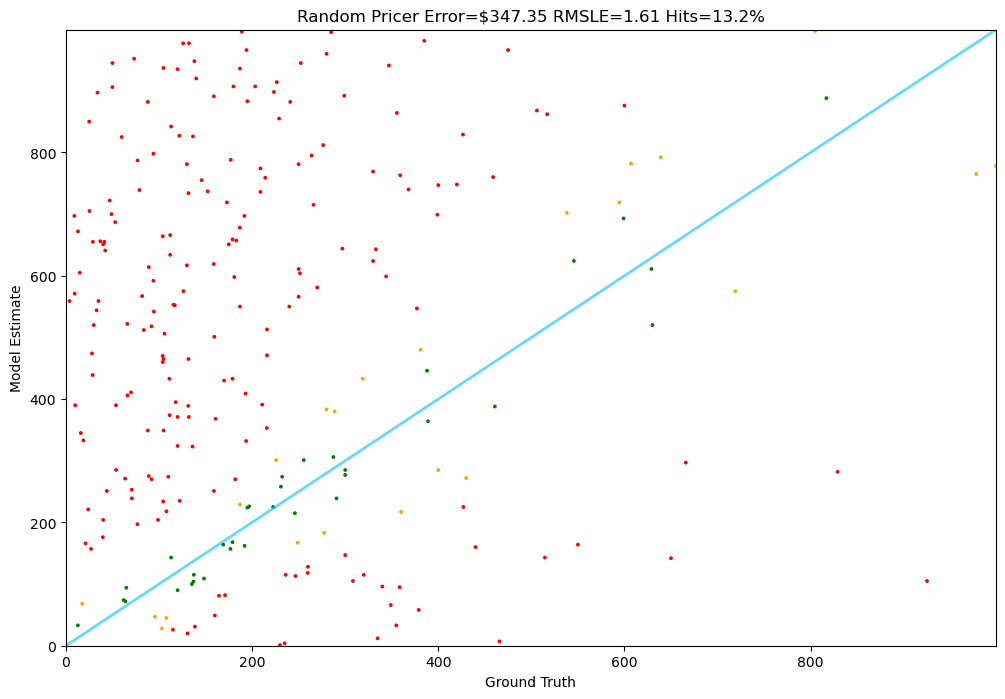

In [45]:
random.seed(42)

Tester.test(random_pricer, test)

In [46]:
# Now a model that predicts the average price

training_prices = [item.price for item in train]
training_average = sum(training_prices) / len(training_prices)

def constant_pricer(item):
    return training_average

1: Guess: $220.87 Truth: $29.00 Error: $191.87 SLE: 4.00 Item: Pavilion Gift Company 46017 Pedigree Pal...
2: Guess: $220.87 Truth: $236.10 Error: $15.23 SLE: 0.00 Item: Electronic Digital Safe Box, Large Secur...
3: Guess: $220.87 Truth: $114.99 Error: $105.88 SLE: 0.42 Item: Tonerider TRH2 Generator Humbucker Set -...
4: Guess: $220.87 Truth: $458.98 Error: $238.11 SLE: 0.53 Item: EPSON EX3200 Multimedia Projector (V11H3...
5: Guess: $220.87 Truth: $829.00 Error: $608.13 SLE: 1.74 Item: Metabo HPT Impact Wrench, Corded, AC Bru...
6: Guess: $220.87 Truth: $43.99 Error: $176.88 SLE: 2.55 Item: Yeele 7x7ft Happy Birthday Round Backdro...
7: Guess: $220.87 Truth: $186.96 Error: $33.91 SLE: 0.03 Item: DISUTOGO Car Seat Covers Fit for Nissan ...
8: Guess: $220.87 Truth: $514.52 Error: $293.65 SLE: 0.71 Item: 2022 Newest HP 17.3'' HD+ Touchscreen La...
9: Guess: $220.87 Truth: $145.86 Error: $75.01 SLE: 0.17 Item: American Standard 1660.525.295 Trevi Del...
10: Guess: $220.87 Truth: $925.00

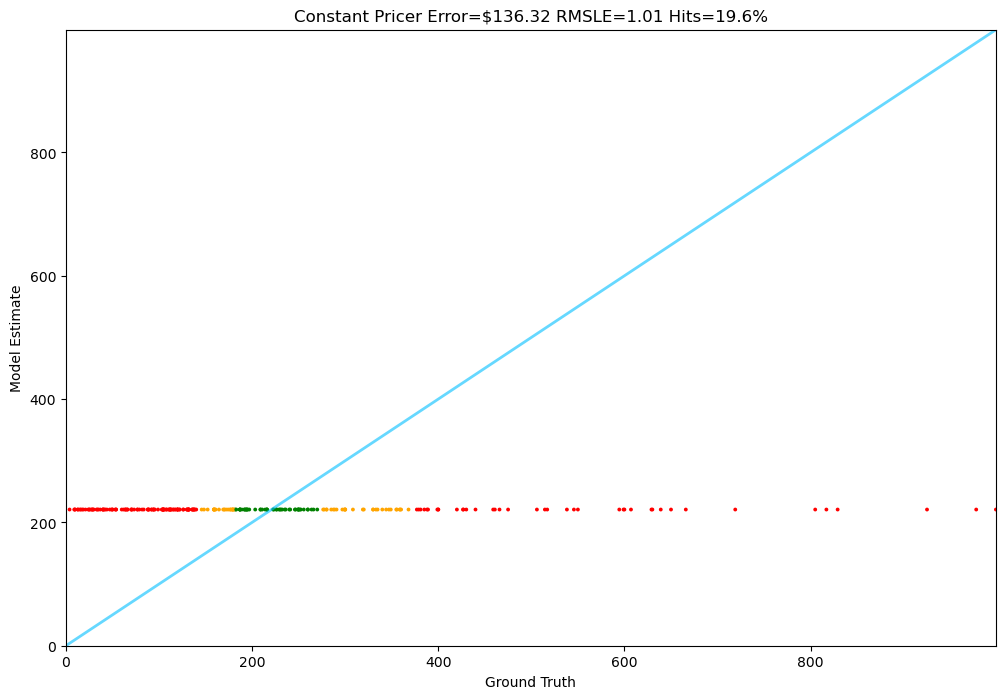

In [47]:
# Run our constant predictor
Tester.test(constant_pricer, test)

In [48]:
train[0].details

'{"Manufacturer": "MGP Caliper Covers", "Brand": "MGP Caliper Covers", "Model": "13008SCV6YL", "Item Weight": "1.74 pounds", "Item model number": "13008SCV6YL", "Is Discontinued By Manufacturer": "No", "Exterior": "Painted", "Manufacturer Part Number": "13008SCV6YL", "Best Sellers Rank": {"Automotive": 503422, "Automotive Replacement Brake Calipers Without Pads": 942}, "Date First Available": "August 11, 2016"}'

In [49]:
# Create a new "features" field on items, and populate it with json parsed from the details dict

for item in train:
    item.features = json.loads(item.details)
for item in test:
    item.features = json.loads(item.details)

# Look at one

In [50]:
train[0].features.keys()

dict_keys(['Manufacturer', 'Brand', 'Model', 'Item Weight', 'Item model number', 'Is Discontinued By Manufacturer', 'Exterior', 'Manufacturer Part Number', 'Best Sellers Rank', 'Date First Available'])

In [51]:
# Look at 20 most common features in training set

feature_count = Counter()
for item in train:
    for f in item.features.keys():
        feature_count[f]+=1

feature_count.most_common(40)

[('Date First Available', 360083),
 ('Item Weight', 350060),
 ('Manufacturer', 349291),
 ('Brand', 339983),
 ('Best Sellers Rank', 330142),
 ('Item model number', 277495),
 ('Product Dimensions', 262182),
 ('Color', 182968),
 ('Is Discontinued By Manufacturer', 170043),
 ('Manufacturer Part Number', 145550),
 ('Material', 136635),
 ('Country of Origin', 121134),
 ('Style', 77283),
 ('Part Number', 74503),
 ('Special Feature', 74237),
 ('Batteries Required?', 73577),
 ('Package Dimensions', 72754),
 ('Item Dimensions LxWxH', 71160),
 ('Included Components', 66944),
 ('Model', 65423),
 ('Item Package Quantity', 58259),
 ('Size', 58119),
 ('Batteries Included?', 56762),
 ('OEM Part Number', 56161),
 ('Special Features', 53516),
 ('Exterior', 50933),
 ('Power Source', 50078),
 ('Vehicle Service Type', 49566),
 ('Finish Type', 45904),
 ('Voltage', 45761),
 ('Mounting Type', 37834),
 ('Model Name', 37378),
 ('Shape', 34549),
 ('Number of Items', 31737),
 ('Finish', 31720),
 ('Connectivity Te

In [52]:
def get_weight(item):
    weight_str = item.features.get('Item Weight')
    if weight_str:
        parts = weight_str.split(' ')
        amount = float(parts[0])
        unit = parts[1].lower()
        if unit=="pounds":
            return amount
        elif unit=="ounces":
            return amount / 16
        elif unit=="grams":
            return amount / 453.592
        elif unit=="milligrams":
            return amount / 453592
        elif unit=="kilograms":
            return amount / 0.453592
        elif unit=="hundredths" and parts[2].lower()=="pounds":
            return amount / 100
        else:
            print(weight_str)
    return None

In [53]:
weights = [get_weight(t) for t in train]
weights = [w for w in weights if w]

4.75 Tons


In [54]:
average_weight = sum(weights)/len(weights)
average_weight

13.645333811899608

In [55]:
def get_weight_with_default(item):
    weight = get_weight(item)
    return weight or average_weight

In [56]:
def get_rank(item):
    rank_dict = item.features.get("Best Sellers Rank")
    if rank_dict:
        ranks = rank_dict.values()
        return sum(ranks)/len(ranks)
    return None

In [57]:
ranks = [get_rank(t) for t in train]
ranks = [r for r in ranks if r]
average_rank = sum(ranks)/len(ranks)
average_rank

382218.37072341837

In [58]:
def get_rank_with_default(item):
    rank = get_rank(item)
    return rank or average_rank

In [59]:
def get_text_length(item):
    return len(item.test_prompt())

In [60]:
def get_category(item):
    return item.category

In [61]:
items[0].category

'Automotive'

In [62]:
def get_features(item):
    return {
        "weight": get_weight_with_default(item),
        "rank": get_rank_with_default(item),
        "text_length": get_text_length(item),
        "category": get_category(item)
    }

In [63]:
# Look at features in a training item
get_features(train[0])

{'weight': 1.74,
 'rank': 252182.0,
 'text_length': 865,
 'category': 'Automotive'}

In [64]:
# A utility function to convert our features into a pandas dataframe

def list_to_dataframe(items):
    features = [get_features(item) for item in items]
    df = pd.DataFrame(features)
    df = pd.get_dummies(df, columns=["category"], dtype=int)
    df['price'] = [item.price for item in items]
    return df

train_df = list_to_dataframe(train)
test_df = list_to_dataframe(test[:250])

4.75 Tons


In [65]:
train_df.head()

,weight,rank,text_length,category_Appliances,category_Automotive,category_Cell_Phones_and_Accessories,category_Electronics,category_Musical_Instruments,category_Office_Products,category_Tools_and_Home_Improvement,category_Toys_and_Games,price
0,1.74,252182.000000,865,0,1,0,0,0,0,0,0,290.15
1,0.40,97298.666667,782,0,1,0,0,0,0,0,0,61.83
2,13.33,716991.000000,824,0,1,0,0,0,0,0,0,349.99
3,7.00,552162.500000,787,0,1,0,0,0,0,0,0,408.49
4,18.66,19942.000000,550,0,1,0,0,0,0,0,0,249.99


In [66]:
# Traditional Linear Regression!

np.random.seed(42)

# Separate features and target
X_train = train_df.drop("price", axis=1)
y_train = train_df["price"]
X_test = test_df.drop("price", axis=1)
y_test = test_df["price"]

# Train a Linear Regression
model = LinearRegression()
model.fit(X_train, y_train)

for feature, coef in zip(X_train.columns, model.coef_):
    print(f"{feature}: {coef}")
print(f"Intercept: {model.intercept_}")

# Predict the test set and evaluate
y_pred = model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Squared Error: {mse}")
print(f"R-squared Score: {r2}")

weight: 0.2346706754565507
rank: 3.412987949592895e-05
text_length: -0.006623644882085103
category_Appliances: 8.641645836128951
category_Automotive: 38.48190543150065
category_Cell_Phones_and_Accessories: -93.48358829983326
category_Electronics: 68.40996243665575
category_Musical_Instruments: 80.25846500720199
category_Office_Products: -22.890983374642204
category_Tools_and_Home_Improvement: -8.476947236495862
category_Toys_and_Games: -70.94045980051561
Intercept: 189.69111446635878
Mean Squared Error: 30370.341105030875
R-squared Score: 0.1040718471941604


In [67]:
# Function to predict price for a new item

def linear_regression_pricer(item):
    features = get_features(item)
    category_list = ["category_Appliances", "category_Automotive", "category_Cell_Phones_and_Accessories",
                     "category_Electronics", "category_Musical_Instruments", "category_Office_Products",
                     "category_Tools_and_Home_Improvement", "category_Toys_and_Games"]
    category_dict = dict(zip(category_list, [0]*len(category_list)))
    category_dict[f"category_{features['category']}"] = 1
    features.update(category_dict)
    features_df = pd.DataFrame([features])
    features_df.drop("category", axis=1, inplace=True)
    return model.predict(features_df)[0]

1: Guess: $116.16 Truth: $29.00 Error: $87.16 SLE: 1.86 Item: Pavilion Gift Company 46017 Pedigree Pal...
2: Guess: $192.95 Truth: $236.10 Error: $43.15 SLE: 0.04 Item: Electronic Digital Safe Box, Large Secur...
3: Guess: $267.01 Truth: $114.99 Error: $152.02 SLE: 0.70 Item: Tonerider TRH2 Generator Humbucker Set -...
4: Guess: $253.88 Truth: $458.98 Error: $205.10 SLE: 0.35 Item: EPSON EX3200 Multimedia Projector (V11H3...
5: Guess: $203.18 Truth: $829.00 Error: $625.82 SLE: 1.97 Item: Metabo HPT Impact Wrench, Corded, AC Bru...
6: Guess: $257.44 Truth: $43.99 Error: $213.45 SLE: 3.06 Item: Yeele 7x7ft Happy Birthday Round Backdro...
7: Guess: $245.22 Truth: $186.96 Error: $58.26 SLE: 0.07 Item: DISUTOGO Car Seat Covers Fit for Nissan ...
8: Guess: $255.56 Truth: $514.52 Error: $258.96 SLE: 0.49 Item: 2022 Newest HP 17.3'' HD+ Touchscreen La...
9: Guess: $188.93 Truth: $145.86 Error: $43.07 SLE: 0.07 Item: American Standard 1660.525.295 Trevi Del...
10: Guess: $256.12 Truth: $925.00 

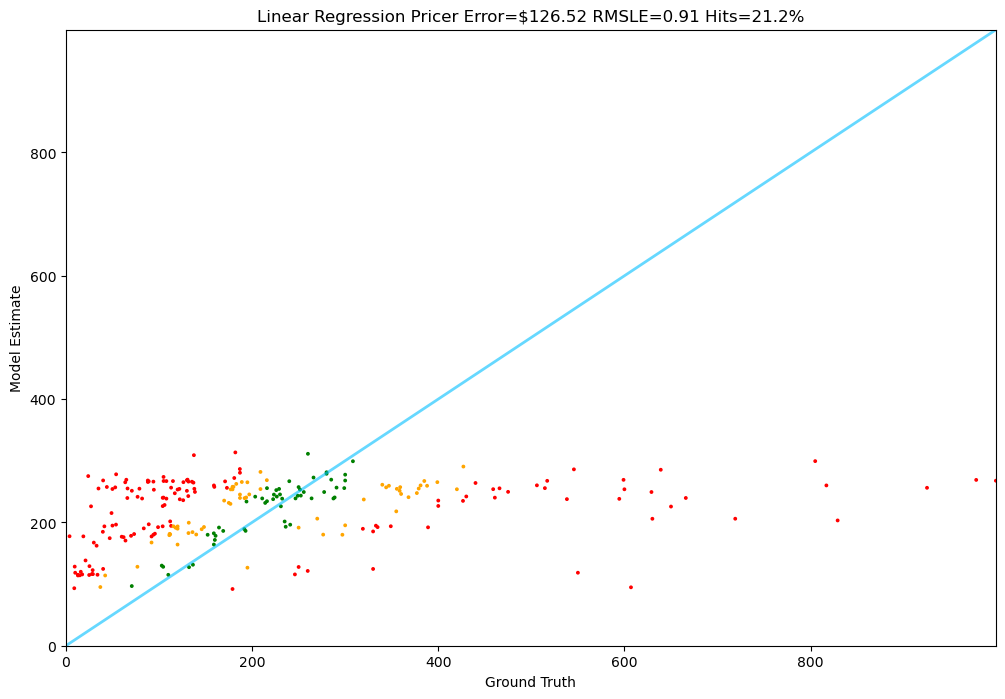

In [68]:
# test it

Tester.test(linear_regression_pricer, test)

In [69]:
# For the next few models, we prepare our documents and prices

prices = np.array([float(item.price) for item in train])
documents = [item.test_prompt() for item in train]

In [70]:
# Use the CountVectorizer for a Bag of Words model

np.random.seed(42)
vectorizer = CountVectorizer(max_features=1000, stop_words='english')
X = vectorizer.fit_transform(documents)
regressor = LinearRegression()
regressor.fit(X, prices)

LinearRegression()

In [71]:
def bow_lr_pricer(item):
    x = vectorizer.transform([item.test_prompt()])
    return max(regressor.predict(x)[0], 0)

1: Guess: $24.00 Truth: $29.00 Error: $5.00 SLE: 0.03 Item: Pavilion Gift Company 46017 Pedigree Pal...
2: Guess: $247.02 Truth: $236.10 Error: $10.92 SLE: 0.00 Item: Electronic Digital Safe Box, Large Secur...
3: Guess: $57.72 Truth: $114.99 Error: $57.27 SLE: 0.46 Item: Tonerider TRH2 Generator Humbucker Set -...
4: Guess: $286.31 Truth: $458.98 Error: $172.67 SLE: 0.22 Item: EPSON EX3200 Multimedia Projector (V11H3...
5: Guess: $274.27 Truth: $829.00 Error: $554.73 SLE: 1.22 Item: Metabo HPT Impact Wrench, Corded, AC Bru...
6: Guess: $90.40 Truth: $43.99 Error: $46.41 SLE: 0.50 Item: Yeele 7x7ft Happy Birthday Round Backdro...
7: Guess: $136.02 Truth: $186.96 Error: $50.94 SLE: 0.10 Item: DISUTOGO Car Seat Covers Fit for Nissan ...
8: Guess: $642.00 Truth: $514.52 Error: $127.48 SLE: 0.05 Item: 2022 Newest HP 17.3'' HD+ Touchscreen La...
9: Guess: $173.99 Truth: $145.86 Error: $28.13 SLE: 0.03 Item: American Standard 1660.525.295 Trevi Del...
10: Guess: $358.78 Truth: $925.00 Error:

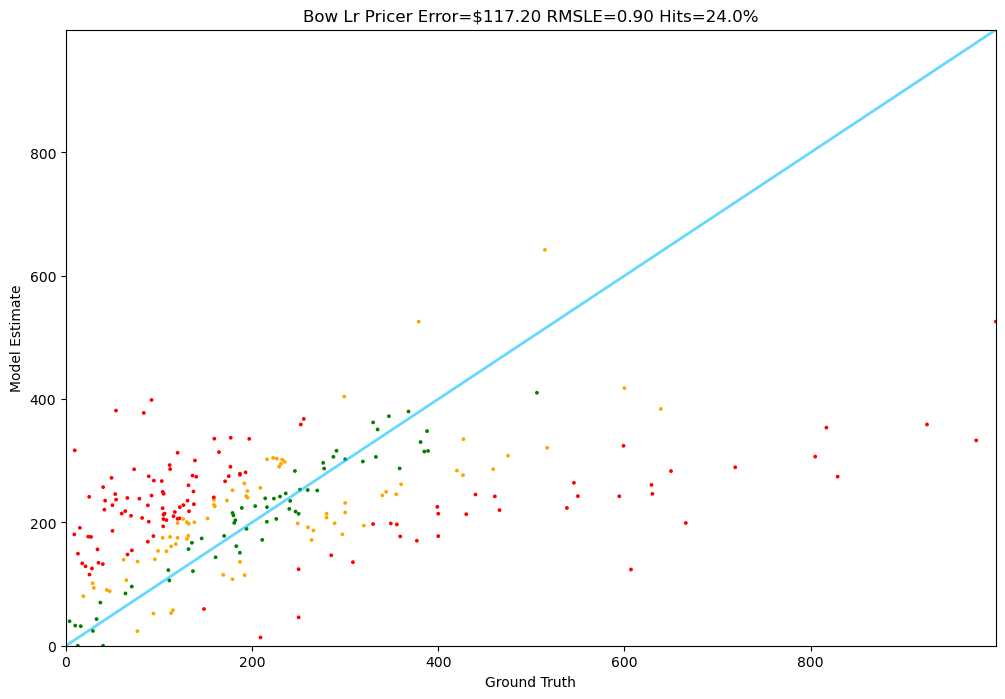

In [72]:
# test it

Tester.test(bow_lr_pricer, test)

In [160]:
# The amazing word2vec model, implemented in gensim NLP library

np.random.seed(42)

# Preprocess the documents
processed_docs = [simple_preprocess(doc) for doc in documents]

# Train Word2Vec model
w2v_model = Word2Vec(sentences=processed_docs, vector_size=400, window=5, min_count=1, workers=8)

In [161]:
# This step of averaging vectors across the document is a weakness in our approach

def document_vector(doc):
    doc_words = simple_preprocess(doc)
    word_vectors = [w2v_model.wv[word] for word in doc_words if word in w2v_model.wv]
    return np.mean(word_vectors, axis=0) if word_vectors else np.zeros(w2v_model.vector_size)

# Create feature matrix
X_w2v = np.array([document_vector(doc) for doc in documents])

In [162]:
# Run Linear Regression on word2vec

word2vec_lr_regressor = LinearRegression()
word2vec_lr_regressor.fit(X_w2v, prices)

LinearRegression()

In [163]:
def word2vec_lr_pricer(item):
    doc = item.test_prompt()
    doc_vector = document_vector(doc)
    return max(0, word2vec_lr_regressor.predict([doc_vector])[0])

1: Guess: $94.00 Truth: $29.00 Error: $65.00 SLE: 1.33 Item: Pavilion Gift Company 46017 Pedigree Pal...
2: Guess: $256.09 Truth: $236.10 Error: $19.99 SLE: 0.01 Item: Electronic Digital Safe Box, Large Secur...
3: Guess: $248.54 Truth: $114.99 Error: $133.55 SLE: 0.59 Item: Tonerider TRH2 Generator Humbucker Set -...
4: Guess: $235.68 Truth: $458.98 Error: $223.30 SLE: 0.44 Item: EPSON EX3200 Multimedia Projector (V11H3...
5: Guess: $261.37 Truth: $829.00 Error: $567.63 SLE: 1.33 Item: Metabo HPT Impact Wrench, Corded, AC Bru...
6: Guess: $105.07 Truth: $43.99 Error: $61.08 SLE: 0.74 Item: Yeele 7x7ft Happy Birthday Round Backdro...
7: Guess: $139.14 Truth: $186.96 Error: $47.82 SLE: 0.09 Item: DISUTOGO Car Seat Covers Fit for Nissan ...
8: Guess: $598.30 Truth: $514.52 Error: $83.78 SLE: 0.02 Item: 2022 Newest HP 17.3'' HD+ Touchscreen La...
9: Guess: $234.32 Truth: $145.86 Error: $88.46 SLE: 0.22 Item: American Standard 1660.525.295 Trevi Del...
10: Guess: $296.87 Truth: $925.00 Err

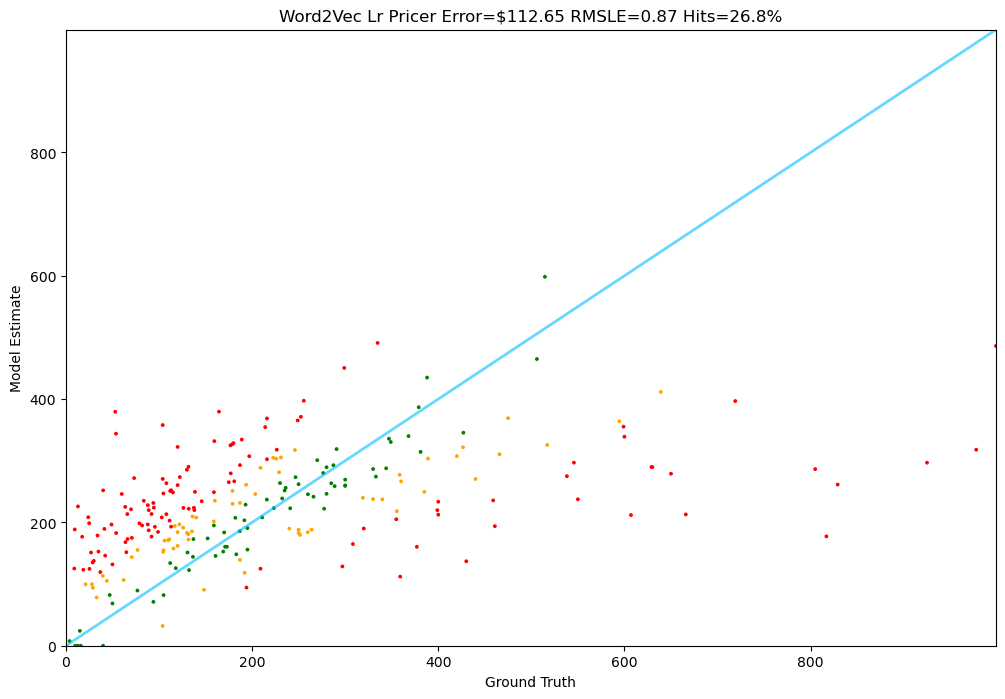

In [164]:
Tester.test(word2vec_lr_pricer, test)

In [165]:
# Support Vector Machines

np.random.seed(42)
svr_regressor = LinearSVR()

svr_regressor.fit(X_w2v, prices)

LinearSVR()

In [166]:
def svr_pricer(item):
    np.random.seed(42)
    doc = item.test_prompt()
    doc_vector = document_vector(doc)
    return max(float(svr_regressor.predict([doc_vector])[0]),0)

1: Guess: $82.98 Truth: $29.00 Error: $53.98 SLE: 1.06 Item: Pavilion Gift Company 46017 Pedigree Pal...
2: Guess: $171.20 Truth: $236.10 Error: $64.90 SLE: 0.10 Item: Electronic Digital Safe Box, Large Secur...
3: Guess: $161.67 Truth: $114.99 Error: $46.68 SLE: 0.11 Item: Tonerider TRH2 Generator Humbucker Set -...
4: Guess: $183.31 Truth: $458.98 Error: $275.67 SLE: 0.84 Item: EPSON EX3200 Multimedia Projector (V11H3...
5: Guess: $232.08 Truth: $829.00 Error: $596.92 SLE: 1.61 Item: Metabo HPT Impact Wrench, Corded, AC Bru...
6: Guess: $70.39 Truth: $43.99 Error: $26.40 SLE: 0.21 Item: Yeele 7x7ft Happy Birthday Round Backdro...
7: Guess: $151.61 Truth: $186.96 Error: $35.35 SLE: 0.04 Item: DISUTOGO Car Seat Covers Fit for Nissan ...
8: Guess: $524.40 Truth: $514.52 Error: $9.88 SLE: 0.00 Item: 2022 Newest HP 17.3'' HD+ Touchscreen La...
9: Guess: $182.41 Truth: $145.86 Error: $36.55 SLE: 0.05 Item: American Standard 1660.525.295 Trevi Del...
10: Guess: $253.81 Truth: $925.00 Error:

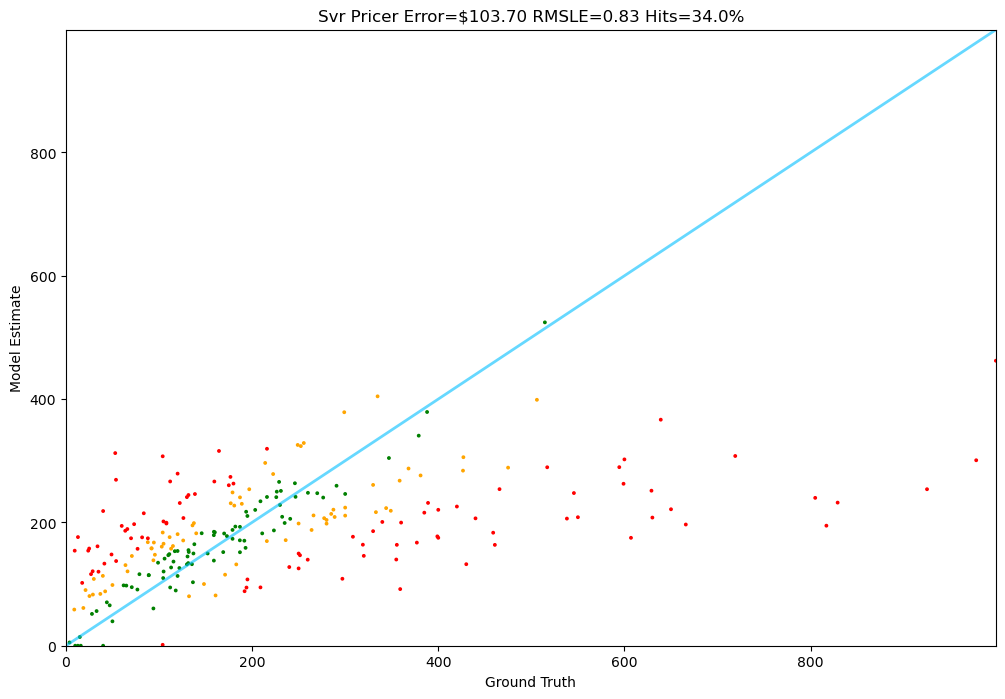

In [167]:
Tester.test(svr_pricer, test)

In [168]:
# And the powerful Random Forest regression

rf_model = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=8)
rf_model.fit(X_w2v, prices)

RandomForestRegressor(n_jobs=8, random_state=42)

In [169]:
def random_forest_pricer(item):
    doc = item.test_prompt()
    doc_vector = document_vector(doc)
    return max(0, rf_model.predict([doc_vector])[0])

1: Guess: $91.44 Truth: $29.00 Error: $62.44 SLE: 1.27 Item: Pavilion Gift Company 46017 Pedigree Pal...
2: Guess: $184.80 Truth: $236.10 Error: $51.30 SLE: 0.06 Item: Electronic Digital Safe Box, Large Secur...
3: Guess: $173.82 Truth: $114.99 Error: $58.83 SLE: 0.17 Item: Tonerider TRH2 Generator Humbucker Set -...
4: Guess: $379.56 Truth: $458.98 Error: $79.42 SLE: 0.04 Item: EPSON EX3200 Multimedia Projector (V11H3...
5: Guess: $335.89 Truth: $829.00 Error: $493.11 SLE: 0.81 Item: Metabo HPT Impact Wrench, Corded, AC Bru...
6: Guess: $41.24 Truth: $43.99 Error: $2.75 SLE: 0.00 Item: Yeele 7x7ft Happy Birthday Round Backdro...
7: Guess: $173.62 Truth: $186.96 Error: $13.34 SLE: 0.01 Item: DISUTOGO Car Seat Covers Fit for Nissan ...
8: Guess: $618.99 Truth: $514.52 Error: $104.47 SLE: 0.03 Item: 2022 Newest HP 17.3'' HD+ Touchscreen La...
9: Guess: $197.63 Truth: $145.86 Error: $51.77 SLE: 0.09 Item: American Standard 1660.525.295 Trevi Del...
10: Guess: $365.20 Truth: $925.00 Error:

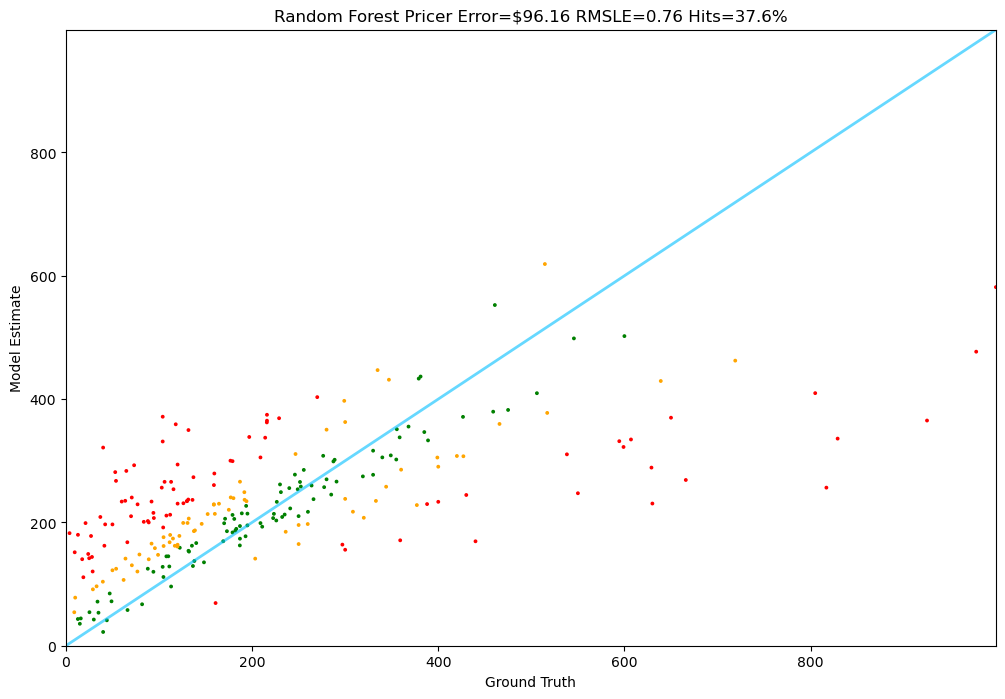

In [170]:
Tester.test(random_forest_pricer, test)

### Now to the LLM model that can estimate how much something costs, from its description

In [171]:
openai = OpenAI()

In [172]:
# Notice that I'm removing the " to the nearest dollar"
# When we train our own models, we'll need to make the problem as easy as possible, 
# but a Frontier model needs no such simplification.

def messages_for(item):
    system_message = "You estimate prices of items. Reply only with the price, no explanation"
    user_prompt = item.test_prompt().replace(" to the nearest dollar", "").replace("\n\nPrice is $", "")
    return [
        {"role": "system", "content": system_message},
        {"role": "user", "content": user_prompt},
        {"role": "assistant", "content": "Price is $"}
    ]

In [173]:
messages_for(test[0])

[{'role': 'system',
  'content': 'You estimate prices of items. Reply only with the price, no explanation'},
 {'role': 'user',
  'content': 'How much does this cost?\n\nPavilion Gift Company 46017 Pedigree Pals Figurine, Himalayan Cat\nMy Pedigree Pals by Pavilion Gift Company is a fabulous range of finely sculpted dogs and cats creatively designed by British artist Dean Kendric. Beautifully smooth to the touch, this collection has fantastic tactile appeal and captures those adoring expressions and unique personalities of our faithful friends. Made with high quality resin 2012 UK Gift of the year Comes uniquely packaged in a tin which becomes a money box; The back of the tin contains a biography about the unique breed Theme Animal, Brand Pavilion Gift Company, Cartoon Character Cat, Room Type Office, Living Room, Bedroom, Pieces 1, Weight 13.9 ounces, Assembly Required No, s 1, Collection Name Animal,'},
 {'role': 'assistant', 'content': 'Price is $'}]

In [174]:
# A utility function to extract the price from a string

def get_price(s):
    s = s.replace('$','').replace(',','')
    match = re.search(r"[-+]?\d*\.\d+|\d+", s)
    return float(match.group()) if match else 0

In [175]:
get_price("The price is roughly $99.99 because blah blah")

99.99

In [176]:
def gpt_4o_mini(item):
    response = openai.chat.completions.create(
        model="gpt-4o-mini", 
        messages=messages_for(item),
        seed=42,
        max_tokens=5
    )
    reply = response.choices[0].message.content
    return get_price(reply)

In [177]:
test[0].price

29.0

1: Guess: $24.99 Truth: $29.00 Error: $4.01 SLE: 0.02 Item: Pavilion Gift Company 46017 Pedigree Pal...
2: Guess: $99.99 Truth: $236.10 Error: $136.11 SLE: 0.73 Item: Electronic Digital Safe Box, Large Secur...
3: Guess: $129.00 Truth: $114.99 Error: $14.01 SLE: 0.01 Item: Tonerider TRH2 Generator Humbucker Set -...
4: Guess: $499.99 Truth: $458.98 Error: $41.01 SLE: 0.01 Item: EPSON EX3200 Multimedia Projector (V11H3...
5: Guess: $329.00 Truth: $829.00 Error: $500.00 SLE: 0.85 Item: Metabo HPT Impact Wrench, Corded, AC Bru...
6: Guess: $25.99 Truth: $43.99 Error: $18.00 SLE: 0.26 Item: Yeele 7x7ft Happy Birthday Round Backdro...
7: Guess: $89.99 Truth: $186.96 Error: $96.97 SLE: 0.53 Item: DISUTOGO Car Seat Covers Fit for Nissan ...
8: Guess: $649.99 Truth: $514.52 Error: $135.47 SLE: 0.05 Item: 2022 Newest HP 17.3'' HD+ Touchscreen La...
9: Guess: $35.00 Truth: $145.86 Error: $110.86 SLE: 1.98 Item: American Standard 1660.525.295 Trevi Del...
10: Guess: $1,200.00 Truth: $925.00 Error

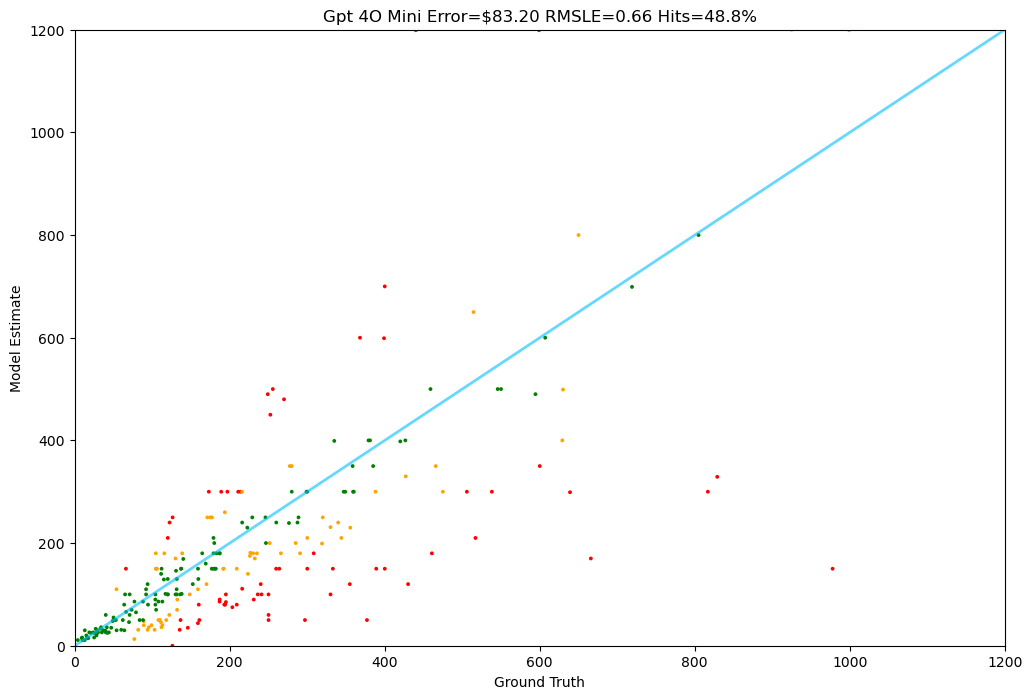

In [178]:
Tester.test(gpt_4o_mini, test)